# Import Libraries

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import re
from nltk.corpus import stopwords
import string

import keras
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.utils.vis_utils import plot_model
from tensorflow.keras.utils import to_categorical
from keras_preprocessing.sequence import pad_sequences
from keras.utils.vis_utils import plot_model
from keras.models import Sequential, load_model
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from tensorflow.keras.optimizers import Adam

import pickle

# Load Data

In [19]:
def load_data(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text
data = load_data("../data/got1.txt")

In [20]:
data[:1000]

'A Game Of Thrones \nBook One of A Song of Ice and Fire \nBy George R. R. Martin \nPROLOGUE \n"We should start back," Gared urged as the woods began to grow dark around them. "The wildlings are \ndead." \n"Do the dead frighten you?" Ser Waymar Royce asked with just the hint of a smile. \nGared did not rise to the bait. He was an old man, past fifty, and he had seen the lordlings come and go. \n"Dead is dead," he said. "We have no business with the dead." \n"Are they dead?" Royce asked softly. "What proof have we?" \n"Will saw them," Gared said. "If he says they are dead, that\'s proof enough for me." \nWill had known they would drag him into the quarrel sooner or later. He wished it had been later rather \nthan sooner. "My mother told me that dead men sing no songs," he put in. \n"My wet nurse said the same thing, Will," Royce replied. "Never believe anything you hear at a woman\'s \ntit. There are things to be learned even from the dead." His voice echoed, too loud in the twilit fores

# Prepare Corpus

In [21]:
def clean_text(text):
    sample = text
    sample = re.sub('[%s]' % re.escape(string.punctuation), '', sample)
    sample = [word for word in sample.split() if word.isalpha()]
    sample = [word.lower() for word in sample]
    sample = " ".join(sample)
    return sample

In [22]:
cleaned_data = clean_text(data)

In [23]:
cleaned_data[:100]

'a game of thrones book one of a song of ice and fire by george r r martin prologue we should start b'

<BarContainer object of 2 artists>

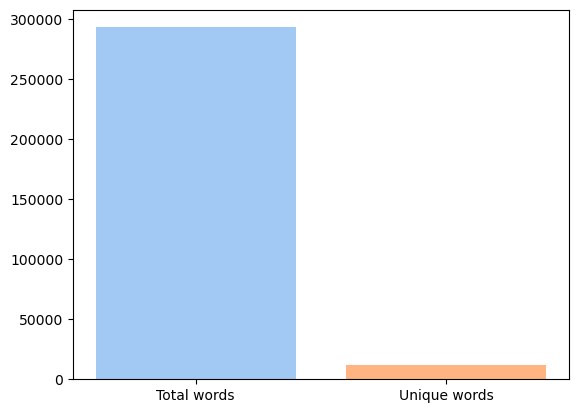

In [24]:
plt.bar(x = ["Total words", "Unique words"], 
        height=[len(cleaned_data.split()), len(set(cleaned_data.split()))], 
        color=sns.color_palette('pastel'))

In [25]:
print('Total Tokens: %d' % len(cleaned_data.split()))
print('Unique Tokens: %d' % len(set(cleaned_data.split())))

Total Tokens: 292883
Unique Tokens: 11923


In [26]:
sequences_doc = []
seq_len = 50
l = seq_len + 1
tokens = [w for w in cleaned_data.split()]

for i in range(l, len(tokens)):
    
    seq = tokens[i-l:i]

    line = ' '.join(seq)
    sequences_doc.append(line)

In [27]:
sequences_doc[:10]

['a game of thrones book one of a song of ice and fire by george r r martin prologue we should start back gared urged as the woods began to grow dark around them the wildlings are dead do the dead frighten you ser waymar royce asked with just the hint',
 'game of thrones book one of a song of ice and fire by george r r martin prologue we should start back gared urged as the woods began to grow dark around them the wildlings are dead do the dead frighten you ser waymar royce asked with just the hint of',
 'of thrones book one of a song of ice and fire by george r r martin prologue we should start back gared urged as the woods began to grow dark around them the wildlings are dead do the dead frighten you ser waymar royce asked with just the hint of a',
 'thrones book one of a song of ice and fire by george r r martin prologue we should start back gared urged as the woods began to grow dark around them the wildlings are dead do the dead frighten you ser waymar royce asked with just the hi

In [28]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sequences_doc)
sequences = tokenizer.texts_to_sequences(sequences_doc)
vocab_size = len(tokenizer.word_index) + 1

In [29]:
sequences = np.array(sequences)
X, y = sequences[:,:-1], sequences[:,-1]
y = to_categorical(y, num_classes=vocab_size)
seq_length = X.shape[1]

# Prepare Model

In [30]:
# def define_model(vocab_size, seq_length):
#     model = Sequential()
#     model.add(Embedding(vocab_size, 50, input_length=seq_length))
#     model.add(LSTM(100, return_sequences=True))
#     model.add(LSTM(100))
#     model.add(Dense(100, activation='relu'))
#     model.add(Dense(vocab_size, activation='softmax'))
#     # compile network
#     model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#     # summarize defined model
#     model.summary()
#     return model

def define_model(vocab_size, seq_length):
    model = Sequential()
    model.add(Embedding(vocab_size, 50, input_length=seq_length))
    model.add(LSTM(100, return_sequences=True))
    model.add(LSTM(100))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(vocab_size, activation='softmax'))
    # compile network
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # summarize defined model
    model.summary()
    return model

# other code remains the same until...
sequences = np.array(sequences)
X, y = sequences[:,:-1], sequences[:,-1]
# y = to_categorical(y, num_classes=vocab_size)  # no longer necessary
seq_length = X.shape[1]

In [31]:
model = define_model(vocab_size, seq_length)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 50, 50)            596200    
                                                                 
 lstm_4 (LSTM)               (None, 50, 100)           60400     
                                                                 
 lstm_5 (LSTM)               (None, 100)               80400     
                                                                 
 dense_4 (Dense)             (None, 100)               10100     
                                                                 
 dense_5 (Dense)             (None, 11924)             1204324   
                                                                 
Total params: 1,951,424
Trainable params: 1,951,424
Non-trainable params: 0
_________________________________________________________________


In [32]:
model.fit(X, np.expand_dims(y, -1), batch_size=128, epochs=10)  # y needs to be the right shape for sparse_categorical_crossentropy

Epoch 1/10
2288/2288 [==============================] - 476s 206ms/step - loss: 6.4959 - accuracy: 0.0682
Epoch 2/10
2288/2288 [==============================] - 473s 207ms/step - loss: 5.9928 - accuracy: 0.0895
Epoch 3/10
2288/2288 [==============================] - 491s 214ms/step - loss: 5.7013 - accuracy: 0.1102
Epoch 4/10
2288/2288 [==============================] - 470s 205ms/step - loss: 5.5031 - accuracy: 0.1204
Epoch 5/10
2288/2288 [==============================] - 495s 216ms/step - loss: 5.3559 - accuracy: 0.1269
Epoch 6/10
2288/2288 [==============================] - 506s 221ms/step - loss: 5.2375 - accuracy: 0.1317
Epoch 7/10
2288/2288 [==============================] - 508s 222ms/step - loss: 5.1364 - accuracy: 0.1360
Epoch 8/10
2288/2288 [==============================] - 523s 229ms/step - loss: 5.0506 - accuracy: 0.1396
Epoch 9/10
2288/2288 [==============================] - 463s 202ms/step - loss: 4.9739 - accuracy: 0.1431
Epoch 10/10
2288/2288 [=======================

In [33]:
# model = define_model(vocab_size, seq_length)

In [34]:
# model.fit(X, y, batch_size=128, epochs=10)

In [43]:
model.save('../data/text_gen_model.h5')
# save the tokenizer
pickle.dump(tokenizer, open('../data/tokenizer_text_gen.pkl', 'wb'))

In [36]:
# load the model
model1 = load_model('text_gen_model.h5')

# Generate Text Sequence

In [37]:
def generate_seq(model, tokenizer, seq_length, seed_text, n_words):
    result = list()
    in_text = seed_text
    # generate a fixed number of words
    for _ in range(n_words):
    # encode the text as integer
        encoded = tokenizer.texts_to_sequences([in_text])[0]
        # truncate sequences to a fixed length
        encoded = pad_sequences([encoded], maxlen=seq_length, truncating='pre')
        # predict probabilities for each word
        yhat = model.predict(encoded, verbose=0)
        yhat = np.argmax(yhat,axis=1)
        print(yhat)
        # map predicted word index to word
        out_word = ''
        for word, index in tokenizer.word_index.items():
            if index == yhat:
                out_word = word
                break
        # append to input
        in_text += ' ' + out_word
        result.append(out_word)
    return ' '.join(result)

In [38]:
seed_text = sequences_doc[np.random.randint(0,len(sequences_doc))]
print(seed_text + '\n')
generate_seq(model, tokenizer, seq_length, seed_text, 50)

maester aemon keeping the wall to his back he slid toward the window and ripped down the curtain moonlight flooded the solar he glimpsed black hands buried in white fur swollen dark fingers tightening around his direwolfs throat ghost was twisting and page snapping legs flailing in the air but he

[8]
[4]
[319]
[186]
[638]
[1]
[75]
[13]
[58]
[4]
[54]
[5]
[1]
[295]
[493]
[6]
[13]
[58]
[4]
[54]
[5]
[1]
[295]
[493]
[6]
[13]
[58]
[4]
[54]
[5]
[1]
[295]
[493]
[6]
[13]
[58]
[4]
[54]
[5]
[1]
[295]
[493]
[6]
[13]
[58]
[4]
[54]
[5]
[1]
[295]


'was a few years ago the king had been a man of the seven kingdoms he had been a man of the seven kingdoms he had been a man of the seven kingdoms he had been a man of the seven kingdoms he had been a man of the seven'

In [39]:
seed_text = sequences_doc[np.random.randint(0,len(sequences_doc))]
print(seed_text + '\n')
generate_seq(model, tokenizer, seq_length, seed_text, 50)[:60]

guards it was to him that bronn turned with a cursory salute they await your command lady lysa said to her lord son fight the boy screamed his arms trembling as they clutched at his chair ser vardis swiveled bringing up his heavy shield bronn turned to face him their swords

[8]
[4]
[319]
[186]
[638]
[1]
[75]
[13]
[58]
[4]
[54]
[5]
[1]
[295]
[493]
[6]
[13]
[58]
[4]
[54]
[5]
[1]
[295]
[493]
[6]
[13]
[58]
[4]
[54]
[5]
[1]
[295]
[493]
[6]
[13]
[58]
[4]
[54]
[5]
[1]
[295]
[493]
[6]
[13]
[58]
[4]
[54]
[5]
[1]
[295]


'was a few years ago the king had been a man of the seven kin'

In [41]:
# pd.read_csv("twitter_parsed_dataset.csv")["Text"][np.random.randint(0, len(pd.read_csv("twitter_parsed_dataset.csv")))]

In [40]:
seed_text = sequences_doc[np.random.randint(0,len(sequences_doc))]
print(seed_text + '\n')
generate_seq(model, tokenizer, seq_length, seed_text, 50)[:60]

holdfasts all across the realm men lift secret toasts to your health while women sew dragon banners and hide them against the day of your return from across the water he gave a massive shrug or so my agents tell me dany had no agents no way of knowing what anyone

[27]
[4]
[54]
[5]
[1]
[295]
[493]
[6]
[20]
[1]
[75]
[13]
[58]
[4]
[54]
[5]
[1]
[295]
[493]
[6]
[20]
[1]
[75]
[13]
[58]
[4]
[54]
[5]
[1]
[295]
[493]
[6]
[13]
[58]
[4]
[54]
[5]
[1]
[295]
[493]
[6]
[13]
[58]
[4]
[54]
[5]
[1]
[295]
[493]
[6]


'is a man of the seven kingdoms he said the king had been a m'

https://colab.research.google.com/drive/1VLG8e7YSEwypxU-noRNhsv5dW4NfTGce

https://colab.research.google.com/github/demmojo/colabrnn/blob/master/colabRNN.ipynb#scrollTo=1rQ4lFinceov

https://colab.research.google.com/github/huggingface/blog/blob/master/notebooks/02_how_to_generate.ipynb#scrollTo=ue2kOQhXTAMU